In [62]:
import numpy as np
import math
import GPy
import matplotlib.pyplot as plt
import seaborn

In [63]:
datstor = np.loadtxt('./../svm.csv', delimiter=",")
full_features = datstor[:, :-1]
full_labels = np.log(datstor[:, -1]).reshape(-1, 1)


In [64]:
def generate_data():
    sample = np.random.choice(datstor.shape[0], size = 32, replace=False)
    X = full_features[sample]
    #X = samp_data[:, :-1]
    #y = samp_data[:, -1].reshape(-1, 1)
    y = full_labels[sample]
    return X, y

X, y = generate_data()


In [65]:
def best_kernel_search(X, y):
    
    kernel = GPy.kern.Matern52(input_dim=X.shape[1], variance = 1.0, lengthscale= 1.0)
    mean = GPy.mappings.Constant(input_dim = X.shape[1], output_dim = 1, value = np.mean(y))
    model = GPy.models.GPRegression(X, y, kernel, noise_var=0.001**2, mean_function=mean)
    model.Gaussian_noise.variance.fix()
    model.optimize_restarts(100, verbose=False)

    n = model.num_data
    k = len(model.optimizer_array)
    log_likelihood = model.log_likelihood()
    
    bic = k * np.log(n) - 2 * log_likelihood
    return model

In [66]:
#start of optimization

In [67]:
datstor = np.loadtxt('./../svm.csv', delimiter=",")

In [68]:
def sample_points(n):
    sample = np.random.choice(datstor.shape[0], size = n, replace=False)
    X = full_features[sample]
    #X = samp_data[:, :-1]
    #y = samp_data[:, -1].reshape(-1, 1)
    y = full_labels[sample]
    return X, y

In [69]:
from scipy.stats import norm


In [70]:
def sample_exp(n, init_features, init_vals, model):
    first_min = np.min(init_vals)
    model.set_XY(init_features, init_vals)
    stor = np.empty(n)
    for i in range(n):
        y_pred, y_var = model.predict(full_features)
        y_std = np.sqrt(y_var)
        prob = np.min(init_vals).reshape(1, 1)- y_pred
        prob_imp = prob / y_std
        EI = ((norm.cdf(prob_imp) * prob_imp) + norm.pdf(prob_imp)) * y_std
        ind = np.argmax(EI)
        point = full_features[ind]
        new = full_labels[ind]
        init_features = np.vstack([init_features, point])
        init_vals = np.vstack([init_vals, new])
        model.set_XY(X = init_features, Y = init_vals)
        #model.optimize()
        stor[i] = (np.min(init_vals)-first_min) / (np.min(full_labels)-first_min)
    n = model.num_data
    k = len(model.optimizer_array)
    log_likelihood = model.log_likelihood()
    
    bic = k * np.log(n) - 2 * log_likelihood
    return stor
   


In [71]:
def random_search(n, init_features, init_vals, model):
    first_min = np.min(init_vals)
    model.set_XY(init_features, init_vals)
    stor = np.empty(n)
    for i in range(n):
        point, new = sample_points(1)
        init_features = np.vstack([init_features, point])
        init_vals = np.vstack([init_vals, new])
        model.set_XY(X = init_features, Y = init_vals)
        #model.optimize()
        stor[i] = (np.min(init_vals)-first_min) / (np.min(full_labels)-first_min)
    n = model.num_data
    k = len(model.optimizer_array)
    log_likelihood = model.log_likelihood()
    return stor
    
    

In [72]:
import warnings
ei_stor = np.empty((20, 150))
rand_stor = np.empty((20, 150))
basemod = best_kernel_search(X, y)
with warnings.catch_warnings(action="ignore"):
    for i in range(20):
        points, vals = sample_points(5)
        ei_stor[i] = sample_exp(150, points, vals, basemod.copy())
        rand_stor[i] = random_search(150, points, vals, basemod.copy())
    

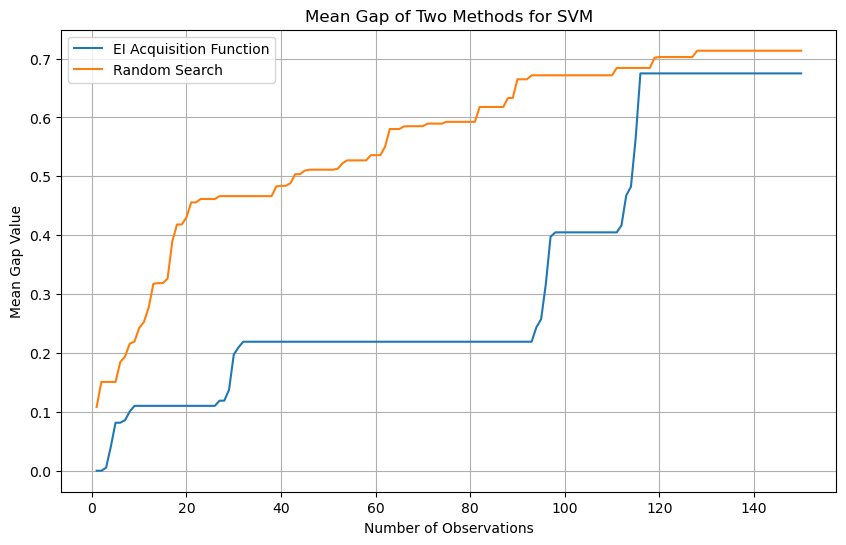

In [73]:
avg1 = np.mean(ei_stor, axis=0)
avg2 = np.mean(rand_stor, axis=0)

# Create x-axis values (column indices)
x1 = np.arange(ei_stor.shape[1]) + 1
x2 = np.arange(rand_stor.shape[1]) + 1

plt.figure(figsize=(10, 6))  # Adjust figure size as needed

plt.plot(x1, avg1, label='EI Acquisition Function')
plt.plot(x2, avg2, label='Random Search')

plt.xlabel('Number of Observations')
plt.ylabel('Mean Gap Value')
plt.title('Mean Gap of Two Methods for SVM')
plt.legend()
plt.grid(True)  # Add a grid for better readability

plt.show()


In [74]:
#paired t test
from scipy import stats
ei_mean = np.mean(ei_stor[:, :30], axis=0)
print(ei_mean[29])
random_search_30 = np.mean(rand_stor[:, :30], axis = 0)
print(random_search_30[29])
t_statistic, p_value = stats.ttest_rel(ei_mean, random_search_30)
print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

0.19703932965733384
0.4663310281569576
T-statistic: -12.453408959231865
P-value: 3.660664613019331e-13
